## Imports

In [1]:
import os
import sys
from pathlib import Path
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import xarray as xr
from datetime import date, timedelta
import cartopy.crs as ccrs
from scipy.ndimage import gaussian_filter
import cartopy.feature as cfeature
from scipy.fft import fft2, fftshift


In [2]:
# Path to the config file (relative or absolute)
CONFIG_FILE = Path("config.json")

# Load config
with open(CONFIG_FILE, "r") as f:
    config = json.load(f)
    
PAR_DIR = config["PAR_DIR"]
if PAR_DIR not in sys.path:
    sys.path.append(PAR_DIR)

DATA_PATH = Path(config["DATA_PATH"])

## Utils

In [3]:
def compute_1d_power_spectrum(image):    
    # Compute 2D FFT and shift zero frequency to center
    f_transform = fftshift(fft2(image))
    
    # Compute power spectrum (magnitude squared)
    power_spectrum = np.abs(f_transform)**2

    # Create a radial distance map
    y, x = np.indices(image.shape)
    center = np.array(image.shape) // 2
    r = np.sqrt((x - center[1])**2 + (y - center[0])**2)
    r = r.astype(np.int32)

    # Compute 1D power spectrum by averaging over rings
    tbin = np.bincount(r.ravel(), power_spectrum.ravel())
    nr = np.bincount(r.ravel())
    radial_profile = tbin / (nr + 1e-8)  # Avoid division by zero

    return radial_profile

In [71]:
def plot_maps(data1, data2, data3,
              cmap1, cmap2, cmap3,
              label1, label2, label3,
              title1, title2, title3,
              extent1, extent2, extent3,
              min_0 = False):
    fig = plt.figure(figsize=(20, 7))
    gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 1], wspace=0.2)

    ax1 = fig.add_subplot(gs[0], projection=ccrs.EuroPP())
    ax2 = fig.add_subplot(gs[1], projection=ccrs.EuroPP())
    ax3 = fig.add_subplot(gs[2], projection=ccrs.EuroPP())

    for ax in [ax1, ax2, ax3]:
        ax.set_extent([-5.63, 9.84, 41.32, 51.123], crs=ccrs.PlateCarree())
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS)
        gl = ax.gridlines(draw_labels=True, linestyle="--", alpha=0.7)
        gl.right_labels = False
        ax.set_aspect('equal')
    
    # set ylims as min and max of all data
    # vmax is the max of the 3 quantile 95%
    vmax = max( np.quantile(data2, 0.95), np.quantile(data3, 0.95))
    vmin = 0 if min_0 else -vmax

    # Plot precipitation
    plot1 = ax1.imshow(data1,
                        extent=extent1,
                        origin='lower',
                        cmap=cmap1,
                        alpha=1,
                        transform=ccrs.PlateCarree(), 
                        vmin=vmin, vmax=vmax)
    # reduce size of colorbar
    fig.colorbar(plot1, ax=ax1, orientation='vertical', label=label1, shrink=0.75)

    # Plot wind speed
    plot2 = ax2.imshow(data2,
                    extent=extent2,
                    origin='upper',
                    cmap=cmap2,
                    alpha=1,
                    transform=ccrs.PlateCarree(), 
                    vmin=vmin, vmax=vmax)
    fig.colorbar(plot2, ax=ax2, orientation='vertical', label=label2, shrink=0.75)

    # Plot additional data
    plot3 = ax3.imshow(data3,
                             extent=extent3,
                             origin='upper',
                             cmap=cmap3,
                             alpha=1,
                             transform=ccrs.PlateCarree(), 
                             vmin=vmin, vmax=vmax)
    fig.colorbar(plot3, ax=ax3, orientation='vertical', label=label3, shrink=0.75)

    # Set titles
    ax1.set_title(title1)
    ax2.set_title(title2)
    ax3.set_title(title3)

    plt.show()

In [72]:
# define a function to plot the 1D power spectrum of a 2D array
def plot_power_spectrum(data1, data2, label1, label2, title):
    p1 = compute_1d_power_spectrum(data1)
    p2 = compute_1d_power_spectrum(data2)
    # plot the 1D power spectrum
    plt.figure(figsize=(10, 5))
    plt.plot(p1, label=label1)
    plt.plot(p2, label=label2)
    plt.title(title)
    plt.legend()
    plt.xlabel('Spatial Frequency')
    plt.ylabel('Power')
    plt.yscale('log')
    plt.grid()
    plt.show()

## RCM historical data

In [73]:
historical_path = '/homedata/aburq/hackathon/r1i1p1f2/historical/sfcWindAdjust'
futur_path = '/homedata/aburq/hackathon/r1i1p1f2/ssp370/sfcWindAdjust'
cnrm_hist = xr.open_dataset(DATA_PATH / historical_path / "regrid.nc")
cnrm_futur = xr.open_dataset(DATA_PATH / futur_path / "regrid.nc")
serpent = xr.open_dataset(DATA_PATH / "serpentflow_sfcWind_CNRM_SAFRAN_2000_2100_ssp370.nc")
gcm = xr.open_dataset(DATA_PATH / "sfcWind_FR_CNRM-ESM2-1_370.nc")

In [74]:
lon_slice = slice(-1.006918, 6.588248)
lat_slice = slice(49.212682, 43.606726)
lat_slice_reverse = slice(43.606726, 49.212682)
rcm_hist_cropped = cnrm_hist.sel(y=lat_slice, x=lon_slice)
rcm_futur_cropped = cnrm_futur.sel(y=lat_slice, x=lon_slice)
serpent_cropped = serpent.sel(lat=lat_slice, lon=lon_slice)
gcm_cropped = gcm.sel(lat=lat_slice_reverse, lon=lon_slice)

In [75]:
min_lon_rcm = (float(rcm_hist_cropped.x.min()))
max_lon_rcm = (float(rcm_hist_cropped.x.max()))
min_lat_rcm = (float(rcm_hist_cropped.y.min()))
max_lat_rcm = (float(rcm_hist_cropped.y.max()))
extent_rcm = [min_lon_rcm, max_lon_rcm, min_lat_rcm, max_lat_rcm]

## Deltas wind GCM

In [76]:
gcm_2000_2020 = gcm_cropped.sel(time=slice("2000-01-01", "2020-12-31"))
gcm_2080_2100 = gcm_cropped.sel(time=slice("2080-01-01", "2100-12-31"))

rcm_2000_2014 = rcm_hist_cropped.sel(time=slice("2000-01-01", "2014-12-31"))
rcm_2015_2020 = rcm_futur_cropped.sel(time=slice("2015-01-01", "2020-12-31"))
rcm_2080_2100 = rcm_futur_cropped.sel(time=slice("2080-01-01", "2100-12-31"))

serpent_2000_2020 = serpent.sel(time=slice("2000-01-01", "2020-12-31"))
serpent_2080_2100 = serpent.sel(time=slice("2080-01-01", "2100-12-31"))

In [77]:
gcm_mean_wind_2000_2020 = gcm_2000_2020.sfcWind.mean(dim="time")
gcm_mean_wind_2080_2100 = gcm_2080_2100.sfcWind.mean(dim="time")

rcm_mean_wind_2000_2014 = rcm_2000_2014.sfcWindAdjust.mean(dim="time")
rcm_mean_wind_2015_2020 = rcm_2015_2020.sfcWindAdjust.mean(dim="time")
rcm_mean_wind_2000_2020 = (rcm_mean_wind_2000_2014*15 + rcm_mean_wind_2015_2020*6) / 21
rcm_mean_wind_2080_2100 = rcm_2080_2100.sfcWindAdjust.mean(dim="time")

serpent_mean_wind_2000_2020 = serpent_2000_2020.SerpentFlow.mean(dim="time")
serpent_mean_wind_2080_2100 = serpent_2080_2100.SerpentFlow.mean(dim="time")

gcm_serp_mean_wind_2000_2020 = serpent_2000_2020.GCM.mean(dim="time")
gcm_serp_mean_wind_2080_2100 = serpent_2080_2100.GCM.mean(dim="time")

In [78]:
delta_mean_rcm = (rcm_mean_wind_2080_2100 - rcm_mean_wind_2000_2020) / rcm_mean_wind_2000_2020 * 100
delta_mean_serpent = (serpent_mean_wind_2080_2100 - serpent_mean_wind_2000_2020) / serpent_mean_wind_2000_2020 * 100
delta_mean_gcm = (gcm_mean_wind_2080_2100 - gcm_mean_wind_2000_2020) / gcm_mean_wind_2000_2020 * 100

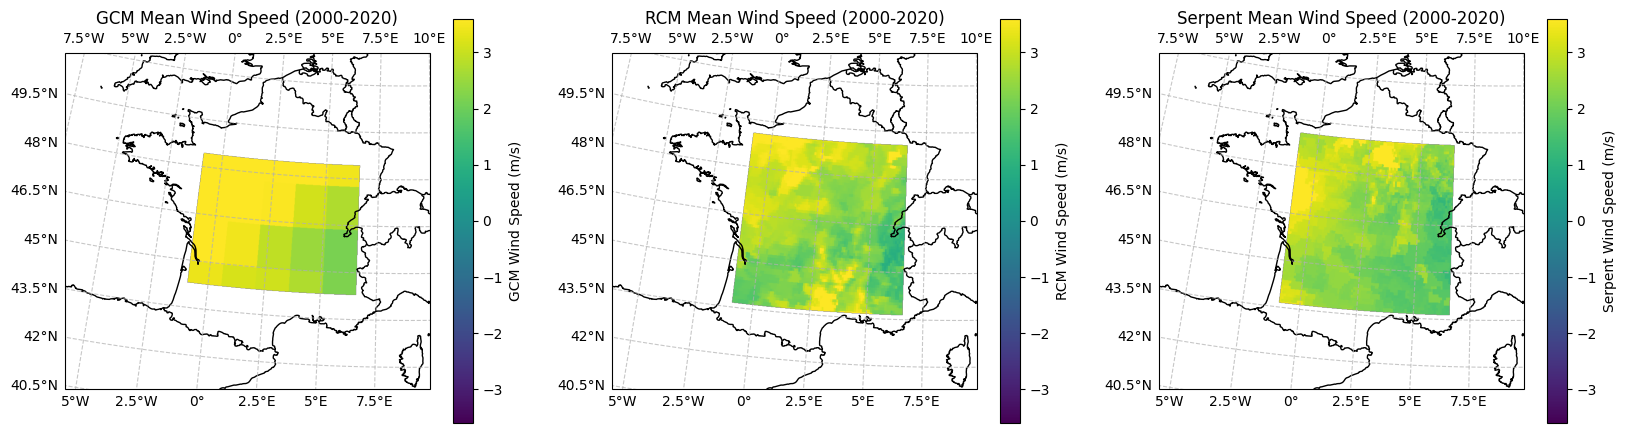

In [79]:
# plot means
plot_maps(gcm_mean_wind_2000_2020, rcm_mean_wind_2000_2020.data, serpent_mean_wind_2000_2020.data, 
          'viridis', 'viridis', 'viridis', 
          'GCM Wind Speed (m/s)', 'RCM Wind Speed (m/s)', 'Serpent Wind Speed (m/s)',
          'GCM Mean Wind Speed (2000-2020)', 'RCM Mean Wind Speed (2000-2020)', 'Serpent Mean Wind Speed (2000-2020)', 
          extent_rcm, extent_rcm, extent_rcm)

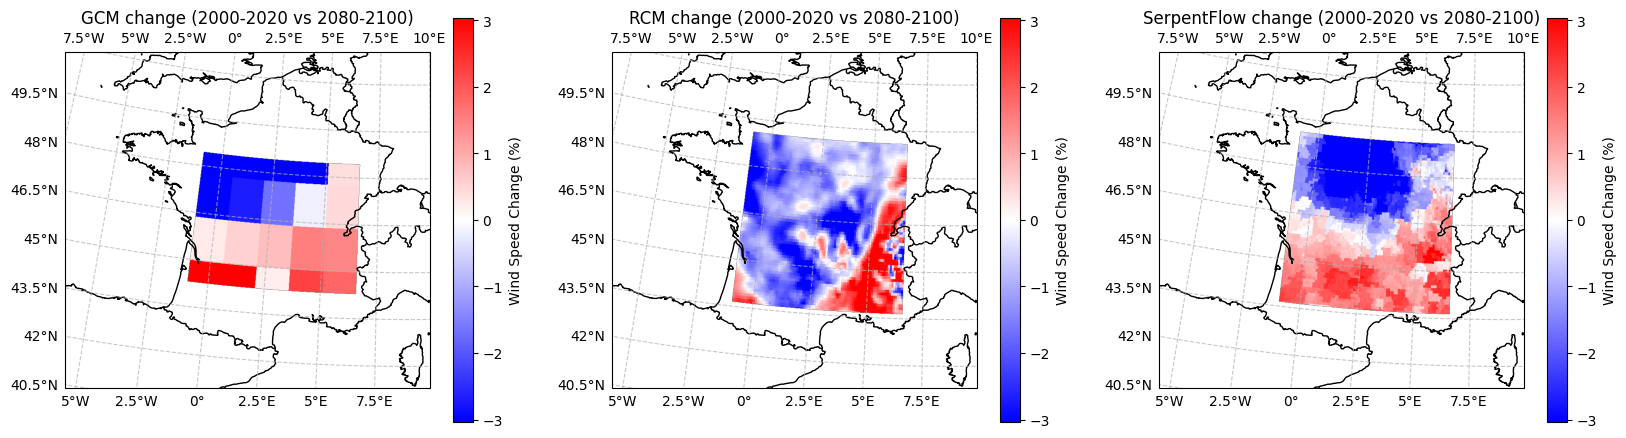

In [80]:
plot_maps(delta_mean_gcm.data, delta_mean_rcm.data, delta_mean_serpent.data, 
          'bwr', 'bwr', 'bwr',
          'Wind Speed Change (%)', 'Wind Speed Change (%)', 'Wind Speed Change (%)',
          'GCM change (2000-2020 vs 2080-2100)', 
          'RCM change (2000-2020 vs 2080-2100)', 
          'SerpentFlow change (2000-2020 vs 2080-2100)', 
          extent_rcm, extent_rcm, extent_rcm)

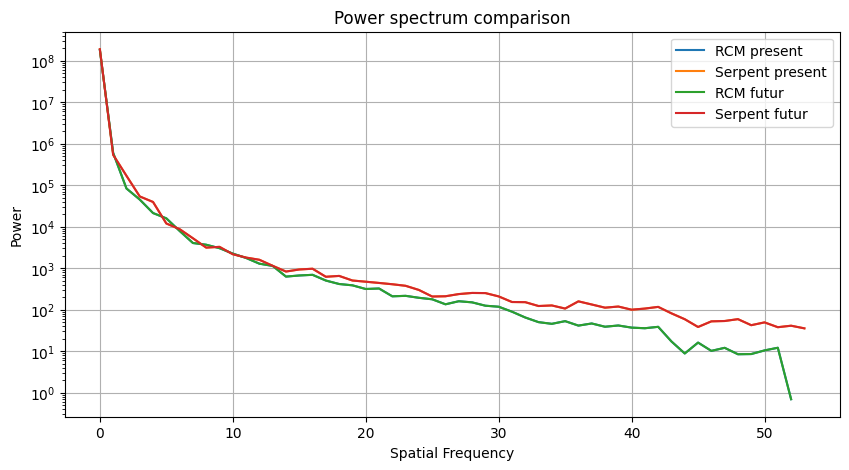

In [ ]:
p1 = compute_1d_power_spectrum(rcm_mean_wind_2000_2020.data)
p2 = compute_1d_power_spectrum(serpent_mean_wind_2000_2020.data)
p3 = compute_1d_power_spectrum(rcm_mean_wind_2080_2100.data)
p4 = compute_1d_power_spectrum(serpent_mean_wind_2080_2100.data)
# plot the 1D power spectrum
plt.figure(figsize=(10, 5))
plt.plot(p1, label="RCM present")
plt.plot(p2, label="Serpent present")
plt.plot(p1, label="RCM futur")
plt.plot(p2, label="Serpent futur")
plt.title('Power spectrum comparison')
plt.legend()
plt.xlabel('Spatial Frequency')
plt.ylabel('Power')
plt.yscale('log')
plt.grid()
plt.show()

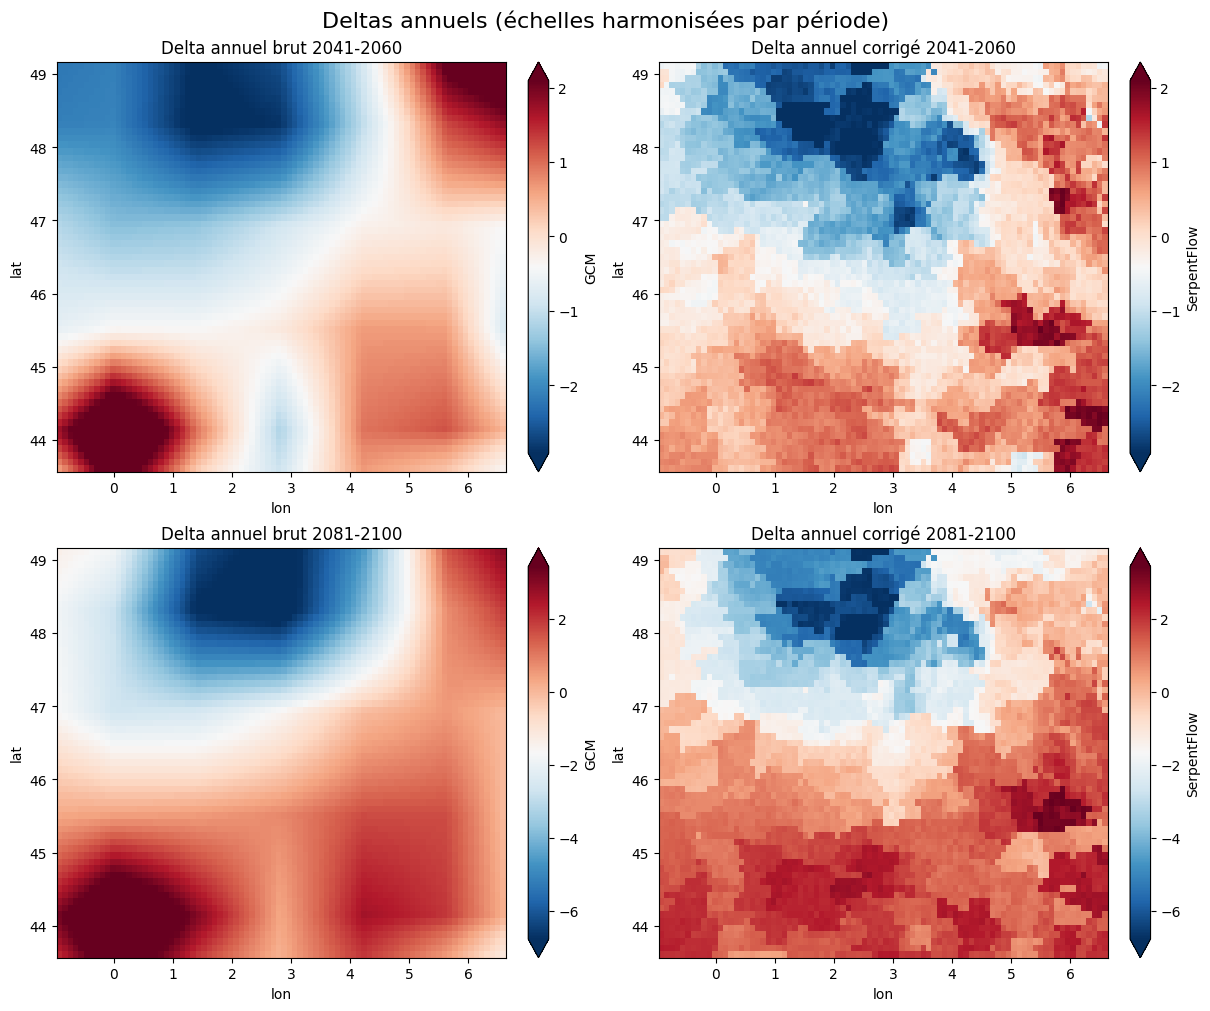

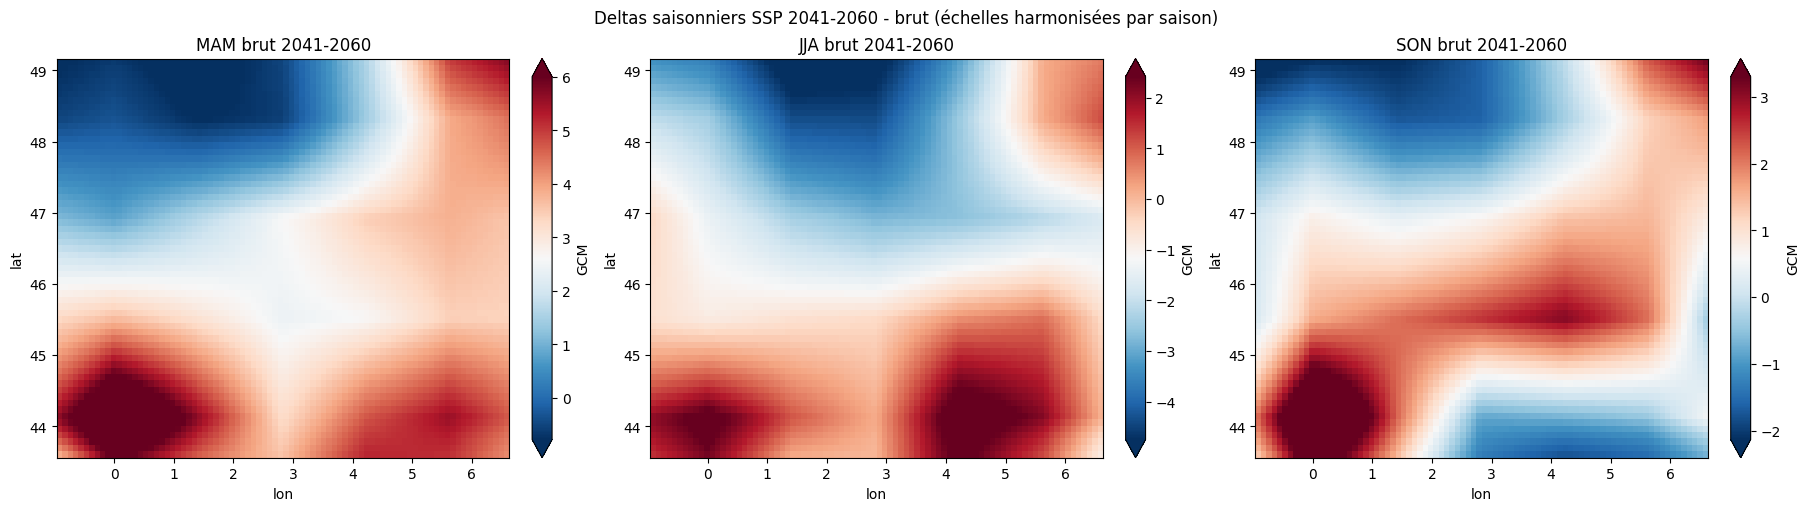

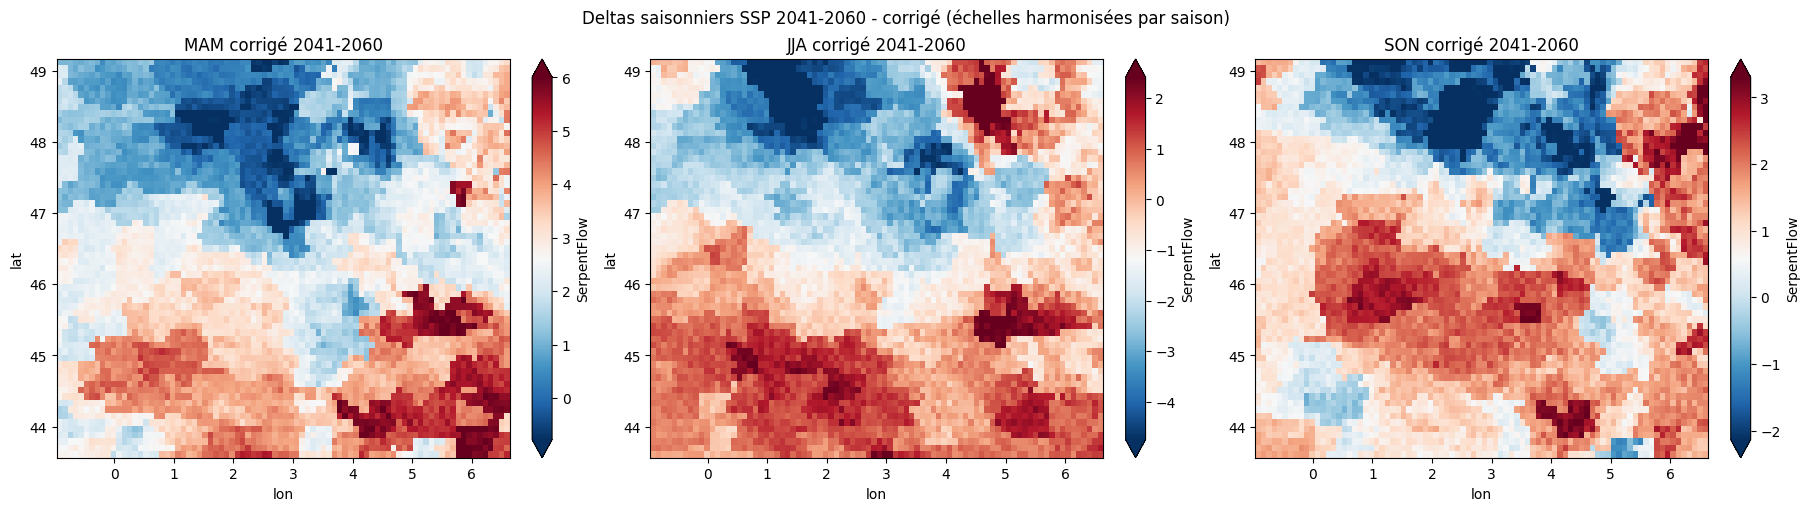

In [15]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# =========================================================
# Préparation
# =========================================================
ds = serpent_cropped.sortby("time").drop_duplicates("time")

periods = {
    "HIST": slice("2001-01-01", "2020-12-31"),
    "SSP_MID": slice("2041-01-01", "2060-12-31"),
    "SSP_END": slice("2081-01-01", "2100-12-31")
}

def mean_period(ds, var, period):
    return ds[var].sel(time=period).mean("time")

def seasonal_mean(ds, var, period):
    return ds[var].sel(time=period).groupby("time.season").mean("time")

# Moyennes annuelles
hist_raw = mean_period(ds, "GCM", periods["HIST"])
hist_corr = mean_period(ds, "SerpentFlow", periods["HIST"])
ssp_mid_raw = mean_period(ds, "GCM", periods["SSP_MID"])
ssp_mid_corr = mean_period(ds, "SerpentFlow", periods["SSP_MID"])
ssp_end_raw = mean_period(ds, "GCM", periods["SSP_END"])
ssp_end_corr = mean_period(ds, "SerpentFlow", periods["SSP_END"])

# Moyennes saisonnières (MAM, JJA, SON)
seasons = ["MAM", "JJA", "SON"]
hist_seas_raw = seasonal_mean(ds, "GCM", periods["HIST"]).sel(season=seasons)
hist_seas_corr = seasonal_mean(ds, "SerpentFlow", periods["HIST"]).sel(season=seasons)
ssp_mid_seas_raw = seasonal_mean(ds, "GCM", periods["SSP_MID"]).sel(season=seasons)
ssp_mid_seas_corr = seasonal_mean(ds, "SerpentFlow", periods["SSP_MID"]).sel(season=seasons)
ssp_end_seas_raw = seasonal_mean(ds, "GCM", periods["SSP_END"]).sel(season=seasons)
ssp_end_seas_corr = seasonal_mean(ds, "SerpentFlow", periods["SSP_END"]).sel(season=seasons)

# Deltas annuels
delta_mid_raw = (ssp_mid_raw - hist_raw)/hist_raw*100
delta_mid_corr = (ssp_mid_corr - hist_corr)/hist_corr*100
delta_end_raw = (ssp_end_raw - hist_raw)/hist_raw*100
delta_end_corr = (ssp_end_corr - hist_corr)/hist_corr*100

# Deltas saisonniers
delta_mid_seas_raw = (ssp_mid_seas_raw - hist_seas_raw)/hist_seas_raw*100
delta_mid_seas_corr = (ssp_mid_seas_corr - hist_seas_corr)/hist_seas_corr*100

# =========================================================
# Calcul des min/max par période pour brut/corrigé
# =========================================================
def get_vmin_vmax(delta1, delta2, pct=(2,98)):
    """Calcule vmin/vmax commun pour deux DataArray pour la même période/saison."""
    combined = np.concatenate([delta1.values.flatten(), delta2.values.flatten()])
    vmin = np.percentile(combined, pct[0])
    vmax = np.percentile(combined, pct[1])
    return vmin, vmax

# =========================================================
# Deltas annuels
# =========================================================
fig, axes = plt.subplots(2,2, figsize=(12,10), constrained_layout=True)

vmin_mid, vmax_mid = get_vmin_vmax(delta_mid_raw, delta_mid_corr)
vmin_end, vmax_end = get_vmin_vmax(delta_end_raw, delta_end_corr)

delta_mid_raw.plot(ax=axes[0,0], cmap="RdBu_r", center=0, vmin=vmin_mid, vmax=vmax_mid)
axes[0,0].set_title("Delta annuel brut 2041-2060")
delta_mid_corr.plot(ax=axes[0,1], cmap="RdBu_r", center=0, vmin=vmin_mid, vmax=vmax_mid)
axes[0,1].set_title("Delta annuel corrigé 2041-2060")
delta_end_raw.plot(ax=axes[1,0], cmap="RdBu_r", center=0, vmin=vmin_end, vmax=vmax_end)
axes[1,0].set_title("Delta annuel brut 2081-2100")
delta_end_corr.plot(ax=axes[1,1], cmap="RdBu_r", center=0, vmin=vmin_end, vmax=vmax_end)
axes[1,1].set_title("Delta annuel corrigé 2081-2100")

plt.suptitle("Deltas annuels (échelles harmonisées par période)", fontsize=16)
plt.show()

# =========================================================
# Deltas saisonniers SSP_MID : 3 saisons brut et corrigé
# =========================================================
fig, axes = plt.subplots(1,3, figsize=(18,5), constrained_layout=True)
for i, season in enumerate(seasons):
    vmin_seas, vmax_seas = get_vmin_vmax(delta_mid_seas_raw.sel(season=season),
                                         delta_mid_seas_corr.sel(season=season))
    delta_mid_seas_raw.sel(season=season).plot(ax=axes[i], cmap="RdBu_r",
                                               center=0, vmin=vmin_seas, vmax=vmax_seas)
    axes[i].set_title(f"{season} brut 2041-2060")
plt.suptitle("Deltas saisonniers SSP 2041-2060 - brut (échelles harmonisées par saison)")
plt.show()

fig, axes = plt.subplots(1,3, figsize=(18,5), constrained_layout=True)
for i, season in enumerate(seasons):
    vmin_seas, vmax_seas = get_vmin_vmax(delta_mid_seas_raw.sel(season=season),
                                         delta_mid_seas_corr.sel(season=season))
    delta_mid_seas_corr.sel(season=season).plot(ax=axes[i], cmap="RdBu_r",
                                                center=0, vmin=vmin_seas, vmax=vmax_seas)
    axes[i].set_title(f"{season} corrigé 2041-2060")
plt.suptitle("Deltas saisonniers SSP 2041-2060 - corrigé (échelles harmonisées par saison)")
plt.show()

## CDFs

In [83]:
safran_1989_2025 = xr.open_dataset(DATA_PATH / "safran_1989_2025.nc")
safran_2000_2020 = safran_1989_2025.sel(time=slice("2000-01-01", "2020-12-31")).sel(x=lon_slice, y=lat_slice)

In [84]:
gcm_2000_2020 = gcm_cropped.sel(time=slice("2000-01-01", "2020-12-31"))
rcm_2000_2020 = rcm_hist_cropped.sel(time=slice("2000-01-01", "2020-12-31"))
serpent_2000_2020 = serpent.sel(time=slice("2000-01-01", "2020-12-31"))

In [85]:
safran_2000_2020.FF_Q.values.flatten().shape

(39950568,)

In [46]:
safran_mean = safran_2000_2020.values.flatten().mean()
safran_min = safran_2000_2020.values.flatten().min()
safran_max = safran_2000_2020.values.flatten().max()

serpent_max = serpent_2000_2020.SerpentFlow.values.flatten().max()
serpent_min = serpent_2000_2020.SerpentFlow.values.flatten().min()
serpent_mean = serpent_2000_2020.SerpentFlow.values.flatten().mean()
serpent_2000_2020_adjusted = ((serpent_2000_2020 - serpent_min) / (serpent_max - serpent_min)) * (safran_max - safran_min) + safran_min

serpent_adjusted_mean = serpent_2000_2020_adjusted.SerpentFlow.values.flatten().mean()
serpent_2000_2020_adjusted = serpent_2000_2020_adjusted - serpent_adjusted_mean + safran_mean

serpent_2000_2020_adjusted_2 = serpent_2000_2020 - serpent_mean + safran_mean

In [47]:
flattened_safran = safran_2000_2020.values.flatten()[
    np.random.choice(safran_2000_2020.values.flatten().shape[0], size=1000000, replace=False)]
flattened_gcm = gcm_2000_2020.sfcWind.values.flatten()
flattened_rcm = rcm_2000_2020.sfcWindAdjust.values.flatten()[
    np.random.choice(rcm_2000_2020.sfcWindAdjust.values.flatten().shape[0], size=1000000, replace=False)]
flattened_serpent = serpent_2000_2020_adjusted_2.SerpentFlow.values.flatten()[
    np.random.choice(serpent_2000_2020_adjusted_2.SerpentFlow.values.flatten().shape[0], size=1000000, replace=False)]

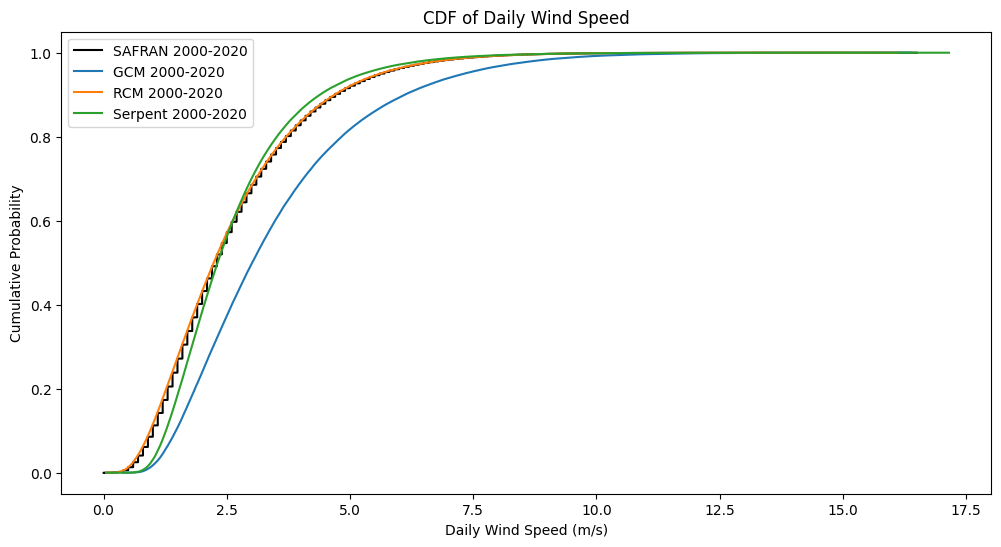

In [48]:
plt.figure(figsize=(12, 6))
plt.plot(np.sort(flattened_safran), np.linspace(0, 1, len(flattened_safran)), label='SAFRAN 2000-2020', color='black')
plt.plot(np.sort(flattened_gcm), np.linspace(0, 1, len(flattened_gcm)), label='GCM 2000-2020')
plt.plot(np.sort(flattened_rcm), np.linspace(0, 1, len(flattened_rcm)), label='RCM 2000-2020')
plt.plot(np.sort(flattened_serpent), np.linspace(0, 1, len(flattened_serpent)), label='Serpent 2000-2020')
plt.xlabel('Daily Wind Speed (m/s)')
plt.ylabel('Cumulative Probability')
plt.title('CDF of Daily Wind Speed')
plt.legend()
plt.show()

## Correlations

In [51]:
def get_corr(ds, variable, lat0, lon0):
    data = ds[variable]
    ref_series = data.sel(lat=lat0, lon=lon0, method='nearest')

    def corr_func(ts):
        return np.corrcoef(ref_series.values, ts)[0, 1]

    corr = xr.apply_ufunc(
        corr_func,
        data,
        input_core_dims=[['time']],
        vectorize=True
    )
    return corr

In [127]:
serpent_corr = get_corr(serpent_2000_2020, "SerpentFlow", 45, 5)
# rename dim x, y to lon, lat in rcm_2000_2020
rcm_2000_2020_rename = rcm_2000_2020.rename({"x": "lon", "y": "lat"})
safran_2000_2020_rename = safran_2000_2020.rename({"x": "lon", "y": "lat"})
rcm_corr = get_corr(rcm_2000_2020_rename, "sfcWindAdjust", 45, 5)
gcm_corr = get_corr(gcm_2000_2020, "sfcWind", 45, 5)
safran_corr = get_corr(safran_2000_2020_rename, "FF_Q", 45, 5)

In [128]:
serpent_corr

<xarray.DataArray 'SerpentFlow' (lat: 64, lon: 87)> Size: 45kB
array([[0.35551395, 0.35775734, 0.35783101, ..., 0.3053919 , 0.30521107,
        0.3093931 ],
       [0.35741471, 0.35669193, 0.35819629, ..., 0.30192469, 0.29904258,
        0.30669804],
       [0.36130788, 0.36020711, 0.35951449, ..., 0.30073622, 0.30453642,
        0.31515338],
       ...,
       [0.42223761, 0.40633451, 0.43300383, ..., 0.57601267, 0.56322008,
        0.56746674],
       [0.43018488, 0.45357739, 0.44238884, ..., 0.58601548, 0.56660501,
        0.5812747 ],
       [0.38677887, 0.422599  , 0.42438266, ..., 0.57843003, 0.5829223 ,
        0.5730957 ]], shape=(64, 87))
Coordinates:
  * lat      (lat) float64 512B 49.3 49.21 49.12 49.03 ... 43.79 43.7 43.61
  * lon      (lon) float64 696B -1.097 -1.007 -0.9165 ... 6.498 6.588 6.679

In [129]:
safran_corr

<xarray.DataArray 'FF_Q' (lat: 62, lon: 84)> Size: 42kB
array([[-0.0889142 , -0.09185453, -0.09185453, ...,  0.0309383 ,
         0.0309383 ,  0.02984547],
       [-0.08987701, -0.11493782, -0.11493782, ...,  0.01397342,
         0.0310968 ,  0.0310968 ],
       [-0.09240633, -0.10737256, -0.10737256, ...,  0.01460675,
        -0.00069349, -0.00069349],
       ...,
       [-0.04734077, -0.04950785, -0.05398483, ...,  0.29116004,
         0.00109512, -0.00453566],
       [-0.05700269, -0.06134463, -0.04721398, ...,  0.0008689 ,
         0.0008689 ,  0.0021475 ],
       [-0.06398833, -0.06134463, -0.06134463, ...,  0.00924339,
         0.00699324,  0.00699324]], shape=(62, 84))
Coordinates:
  * lon      (lon) float64 672B -0.9165 -0.8261 -0.7357 ... 6.407 6.498 6.588
  * lat      (lat) float64 496B 49.12 49.03 48.94 48.85 ... 43.79 43.7 43.61

In [130]:
rcm_corr

<xarray.DataArray 'sfcWindAdjust' (lat: 62, lon: 84)> Size: 42kB
array([[ 0.05251505,  0.0568032 ,  0.06090605, ...,  0.13213029,
         0.1244925 ,  0.11964639],
       [ 0.05637502,  0.06072912,  0.06539152, ...,  0.13917173,
         0.12934205,  0.12236121],
       [ 0.05789654,  0.06275811,  0.06835618, ...,  0.14875611,
         0.13205703,  0.12146441],
       ...,
       [ 0.04535045,  0.03470856,  0.02405776, ...,  0.0380197 ,
        -0.02575373, -0.04122013],
       [ 0.03040349,  0.02318087,  0.01915514, ..., -0.01241612,
        -0.04672908, -0.04751952],
       [ 0.03619402,  0.02925229,  0.02555156, ..., -0.02758995,
        -0.05830588, -0.06368266]], shape=(62, 84))
Coordinates:
  * lon      (lon) float64 672B -0.9165 -0.8261 -0.7357 ... 6.407 6.498 6.588
  * lat      (lat) float64 496B 49.12 49.03 48.94 48.85 ... 43.79 43.7 43.61

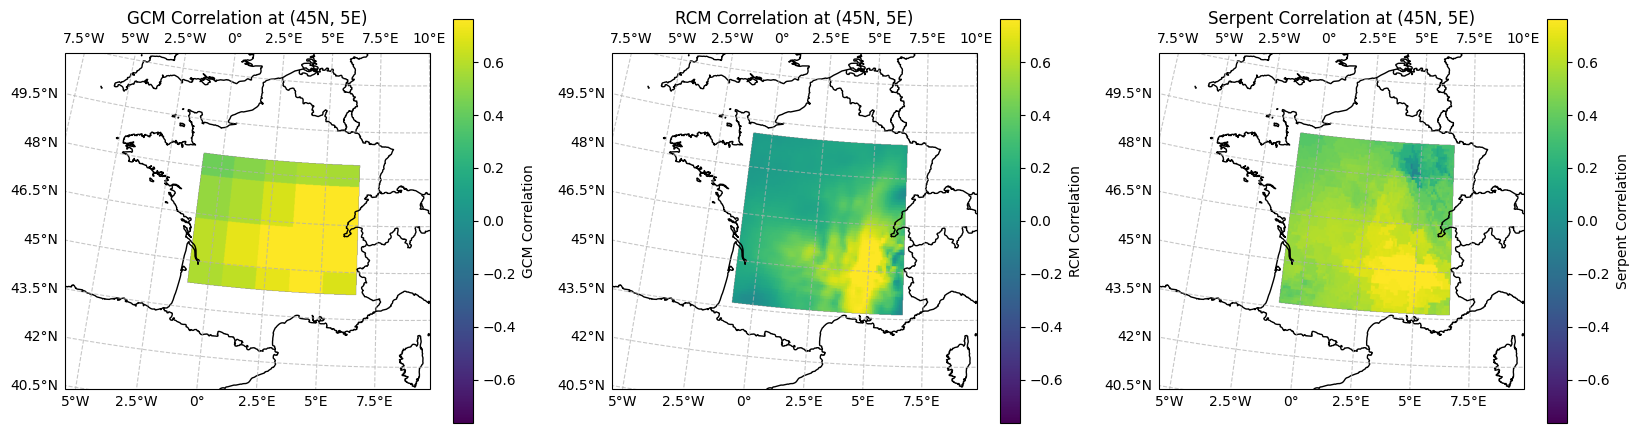

In [138]:
plot_maps(gcm_corr.data, rcm_corr.data, serpent_corr.data,
          'viridis', 'viridis', 'viridis',
          'GCM Correlation', 'RCM Correlation', 'Serpent Correlation',
          'GCM Correlation at (45N, 5E)', 
          'RCM Correlation at (45N, 5E)', 
          'Serpent Correlation at (45N, 5E)',
          extent_rcm, extent_rcm, extent_rcm,
          min_0 = False)   